In [ ]:
import scanpy as sc
import bbknn  # pip install bbknn
import matplotlib.pyplot as plt
import numpy as np

# 1. Read both datasets --------------------------------------
adata= sc.read_h5ad("/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/adata_celltagMulti_scvi_integrated_2.h5ad") 

In [8]:
adata.obs["batch"].unique()

['multi', 'tag']
Categories (2, object): ['multi', 'tag']

In [9]:
import numpy as np

# 1) split by batch
is_test    = adata.obs["batch"] == "multi"
adata_test = adata[is_test].copy()
adata_train= adata[~is_test].copy()

print(f"train cells: {adata_train.n_obs}; test cells: {adata_test.n_obs}")

# 2) overwrite .X with the denoised counts
for ad in (adata_train, adata_test):
    # copy the denoised NB‐mean back into the primary matrix:
    ad.X = ad.layers["scvi_recon"].astype(np.float32)

# 3) now you can feed adata_train.X / adata_test.X straight into your supervised pipeline
#    (e.g. LCL_Eval, KNN, model.get_features(), etc.)

print("test cells: ",  adata_test.X.shape)
print("train cells:",   adata_train.X.shape)

train cells: 6534; test cells: 22238
test cells:  (22238, 1960)
train cells: (6534, 1960)


In [10]:
adata_test.write_h5ad("adata_test_multi_scvi_decodeCount.h5ad")
adata_train.write_h5ad("adata_train_tag_scvi_decodeCount.h5ad")

In [6]:
# create a boolean mask where batch == 'multi'
is_test = adata.obs['batch'] == 'multi'

# subset into test and train AnnData objects
adata_test  = adata[is_test].copy()
adata_train = adata[~is_test].copy()

# sanity‐check sizes
print("test cells: ", adata_test.n_obs)
print("train cells:", adata_train.n_obs)

test cells:  226614
train cells: 6534


In [8]:
import numpy as np
from scipy import sparse

if sparse.issparse(adata.X):
    vals = adata.X.data
else:
    vals = adata.X.ravel()

print("min, max, mean, median:", 
      np.min(vals), np.max(vals), np.mean(vals), np.median(vals))

all_int = np.all(vals.astype(int) == vals)
print("all values integer? →", all_int)

print("layers:", list(adata.layers.keys()))
if adata.raw is not None:
    raw_vals = adata.raw.X.data if sparse.issparse(adata.raw.X) else adata.raw.X.ravel()
    print("adata.raw → min/max:", raw_vals.min(), raw_vals.max())

min, max, mean, median: -13.654120199824982 10.0 -0.0052786280459139155 -0.14336843582502348
all values integer? → False
layers: []


In [12]:
adata_test.write_h5ad("adata_test_multi.h5ad")
adata_train.write_h5ad("adata_train_tag.h5ad")

In [14]:
adata_test.obs["assigned_lineage"]

B4D3-RNA-r1-1_AAACCCAAGCCTCTCT-1              NaN
B4D3-RNA-r1-1_AAACCCACAAAGTATG-1              NaN
B4D3-RNA-r1-1_AAACCCACACTCTAGA-1    Lineage:29424
B4D3-RNA-r1-1_AAACCCACAGCAGAAC-1              NaN
B4D3-RNA-r1-1_AAACCCATCCACGGAC-1              NaN
                                        ...      
D0HF2-RNA_TTTGTCATCACCGTAA-1                  NaN
D0HF2-RNA_TTTGTCATCACTTCAT-1                  NaN
D0HF2-RNA_TTTGTCATCCCATTAT-1                  NaN
D0HF2-RNA_TTTGTCATCGCTTAGA-1                  NaN
D0HF2-RNA_TTTGTCATCTTTACAC-1                  NaN
Name: assigned_lineage, Length: 226614, dtype: category
Categories (18916, object): ['Lineage:9', 'Lineage:116', 'Lineage:118', 'Lineage:121', ..., 'Lineage:66818', 'Lineage:66819', 'Lineage:66821', 'Lineage:66824']

In [15]:
import pandas as pd

# grab the assigned_lineage column
lineages = adata_test.obs['assigned_lineage']

# count unique (non-NA) lineages
n_lineages = lineages.nunique(dropna=True)

# count how many are NA
n_missing = lineages.isna().sum()

print(f"Number of unique lineages (excluding NA): {n_lineages}")
print(f"Number of cells with missing lineage (NA):   {n_missing}")

Number of unique lineages (excluding NA): 18916
Number of cells with missing lineage (NA):   179312


In [16]:
import pandas as pd

# 1. Extract only the non‐NA lineages
lineages = adata_test.obs['assigned_lineage'].dropna()

# 2. Count how many cells per lineage
lineage_sizes = lineages.value_counts()

# 3. Get summary statistics
summary = lineage_sizes.describe()
print(summary)

count    18916.000000
mean         2.500634
std         10.032933
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        690.000000
Name: count, dtype: float64


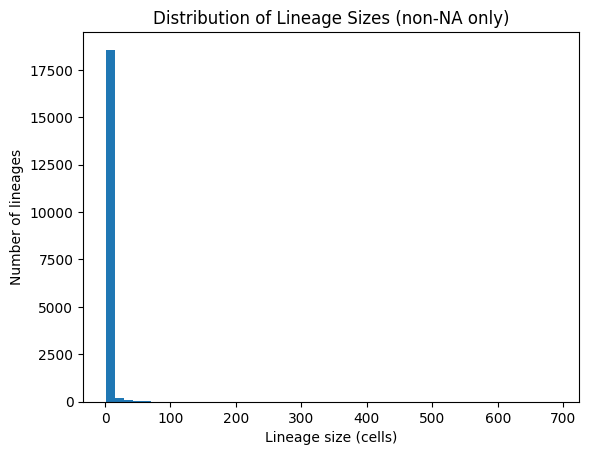

In [20]:
# after you’ve confirmed non‐NA values exist…
lineage_sizes = (
    adata_test
    .obs['assigned_lineage']
    .dropna()
    .value_counts()
    .values
)

plt.figure()
plt.hist(lineage_sizes, bins=50)
plt.xlabel('Lineage size (cells)')
plt.ylabel('Number of lineages')
plt.title('Distribution of Lineage Sizes (non‐NA only)')
plt.show()

In [21]:
# 1. Get counts per lineage (excluding NaN)
lineage_counts = adata_test.obs['assigned_lineage'].value_counts(dropna=True)

# 2. Count how many lineages have size == 1
singleton_lineages = (lineage_counts == 1).sum()

# 3. (Optional) What fraction of all lineages is that?
total_lineages = lineage_counts.size
fraction_singletons = singleton_lineages / total_lineages

print(f"Lineages with exactly one cell: {singleton_lineages}")
print(f"Total non‐NA lineages:          {total_lineages}")
print(f"Fraction singletons:             {fraction_singletons:.2%}")

Lineages with exactly one cell: 12385
Total non‐NA lineages:          18916
Fraction singletons:             65.47%


In [22]:
adata_train.X.shape

(6534, 1960)

In [5]:
lineage_counts = adata_test.obs['assigned_lineage'].dropna().value_counts()

filtered_sizes = lineage_counts[lineage_counts > 1].values

plt.figure()
plt.hist(filtered_sizes, bins='auto')

# zoom in
plt.xlim(0, 50)    # show only sizes 0–50
plt.ylim(0, 1000)   # show counts up to 200

plt.xlabel('Lineage size (number of cells)')
plt.ylabel('Number of lineages')
plt.title('Distribution of Lineage Sizes (>1 cells)')
plt.show()

NameError: name 'adata_test' is not defined

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


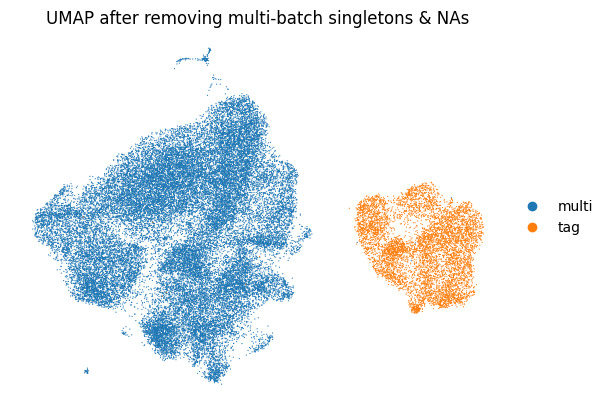

In [4]:
import scanpy as sc

# 1. Compute lineage‐size per cell
#    Count non‐NA assignments
lineage_counts = adata.obs['assigned_lineage'].value_counts(dropna=True)
#    Map back to each cell (NaNs stay NaN)
lineage_size = adata.obs['assigned_lineage'].map(lineage_counts)

# 2. Build a boolean mask to drop:
#    – cells in batch “multi” with lineage size == 1
#    – OR cells with no lineage assignment (NaN)
to_drop = (
    (adata.obs['batch'] == 'multi') &
    ((lineage_size == 1) | (adata.obs['assigned_lineage'].isna()))
)

# 3. Subset the AnnData
adata_filtered = adata[~to_drop].copy()

# 4. Recompute neighbors & UMAP on the filtered data
#    (replace n_pcs/use_rep with whatever you used originally)
sc.pp.neighbors(adata_filtered, use_rep='X_pca', n_pcs=40)
sc.tl.umap(adata_filtered)

# 5. Plot the new UMAP
sc.pl.umap(
    adata_filtered,
    color='batch',
    title='UMAP after removing multi‐batch singletons & NAs',
    frameon=False
)

# 6. (Optional) Save the filtered object
# adata_filtered.write_h5ad("adata_filtered_no_multi_singletons.h5ad")